# Model Classification

## Import module

In [12]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation,BatchNormalization

## Load data

In [13]:
data_train = '/kaggle/input/cats-and-dogs-image-classification/train'
data_test = '/kaggle/input/cats-and-dogs-image-classification/test'

filepaths = []
labels = []
label_map = {
    'dogs': 0,
    'cats': 1
}

## Load train file
folds = os.listdir(data_train)
for item in folds:
    # Get fold path
    foldpath = os.path.join(data_train, item)
    for file in os.listdir(foldpath):
        # Get image path
        image_path = os.path.join(foldpath, file)

        # Save label in labels
        labels.append(item)

        # Save image path
        filepaths.append(image_path)

train_df = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})
train_df

,filepaths,labels
0,/kaggle/input/cats-and-dogs-image-classificati...,dogs
1,/kaggle/input/cats-and-dogs-image-classificati...,dogs
2,/kaggle/input/cats-and-dogs-image-classificati...,dogs
3,/kaggle/input/cats-and-dogs-image-classificati...,dogs
4,/kaggle/input/cats-and-dogs-image-classificati...,dogs
...,...,...
552,/kaggle/input/cats-and-dogs-image-classificati...,cats
553,/kaggle/input/cats-and-dogs-image-classificati...,cats
554,/kaggle/input/cats-and-dogs-image-classificati...,cats
555,/kaggle/input/cats-and-dogs-image-classificati...,cats


In [14]:
## Reset to load test file
filepaths = []
labels = []

## Load test file
folds = os.listdir(data_test)
for item in folds:
    # Get fold path
    foldpath = os.path.join(data_test, item)
    for file in os.listdir(foldpath):
        # Get image path
        image_path = os.path.join(foldpath, file)

        # Save label in labels
        labels.append(item)

        # Save image path
        filepaths.append(image_path)

test_df = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})
test_df

,filepaths,labels
0,/kaggle/input/cats-and-dogs-image-classificati...,dogs
1,/kaggle/input/cats-and-dogs-image-classificati...,dogs
2,/kaggle/input/cats-and-dogs-image-classificati...,dogs
3,/kaggle/input/cats-and-dogs-image-classificati...,dogs
4,/kaggle/input/cats-and-dogs-image-classificati...,dogs
...,...,...
135,/kaggle/input/cats-and-dogs-image-classificati...,cats
136,/kaggle/input/cats-and-dogs-image-classificati...,cats
137,/kaggle/input/cats-and-dogs-image-classificati...,cats
138,/kaggle/input/cats-and-dogs-image-classificati...,cats


## PreProcessing data

In [15]:
# Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

def preprocess_image(image):
    return image.astype('float32') / 255. 
    
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    seed=42, 
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical', 
    seed=42,
    subset='validation'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    seed=42,
    subset='training'
)

Found 446 validated image filenames belonging to 2 classes.
Found 111 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.


## Classification model

In [16]:
## Use Transfer Learning technique
def create_model():
    base_model = MobileNetV2(
        include_top = False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="max",
        classes=1000,
        classifier_activation="softmax",
        name="inception_resnet_v2"
    )
    base_model.trainable =  False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')  
    ])

    model.compile(optimizer=Adamax(learning_rate=0.0001),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
        )
    
    return model

model = create_model()
model.summary()

2025-04-25 01:53:59.363226: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,088,482 (11.78 MB)

 Trainable params: 830,498 (3.17 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
## Setting Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

## Setting to save model checkpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

## Model Fit
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]  # Add callbacks here
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6099 - loss: 0.7574 - val_accuracy: 0.5856 - val_loss: 0.7370
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7432 - loss: 0.4484 - val_accuracy: 0.7117 - val_loss: 0.5343
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8499 - loss: 0.3629 - val_accuracy: 0.6486 - val_loss: 0.7025
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8570 - loss: 0.3135 - val_accuracy: 0.7748 - val_loss: 0.4328
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8736 - loss: 0.2739 - val_accuracy: 0.6396 - val_loss: 0.7675
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8838 - loss: 0.2699 - val_accuracy: 0.8739 - val_loss: 0.3656
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8805 - loss: 0.2568 - val_accuracy: 0.7838 - val_loss: 0.5535
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8771 - loss: 0.3128 - val_accuracy: 0.8288 - val_loss:

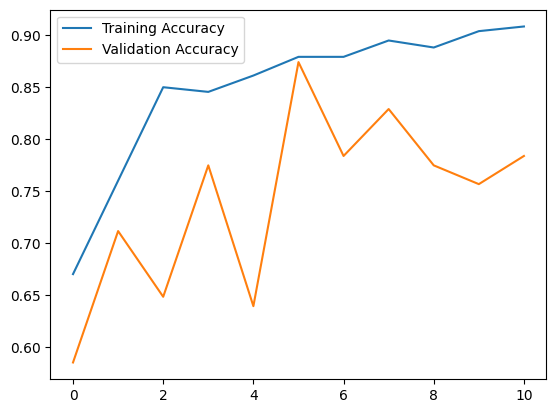

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [19]:
train_score = model.evaluate(train_generator)
valid_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ",test_score[1])

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8947 - loss: 0.2435
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 931ms/step - accuracy: 0.8301 - loss: 0.4241
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 817ms/step - accuracy: 0.8065 - loss: 0.4484
Train Loss:  0.24694757163524628
Train Accuracy:  0.8923766613006592
--------------------
Validation Loss:  0.45733994245529175
Validation Accuracy:  0.8018018007278442
--------------------
Test Loss:  0.4112577736377716
Test Accuracy:  0.8392857313156128


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  


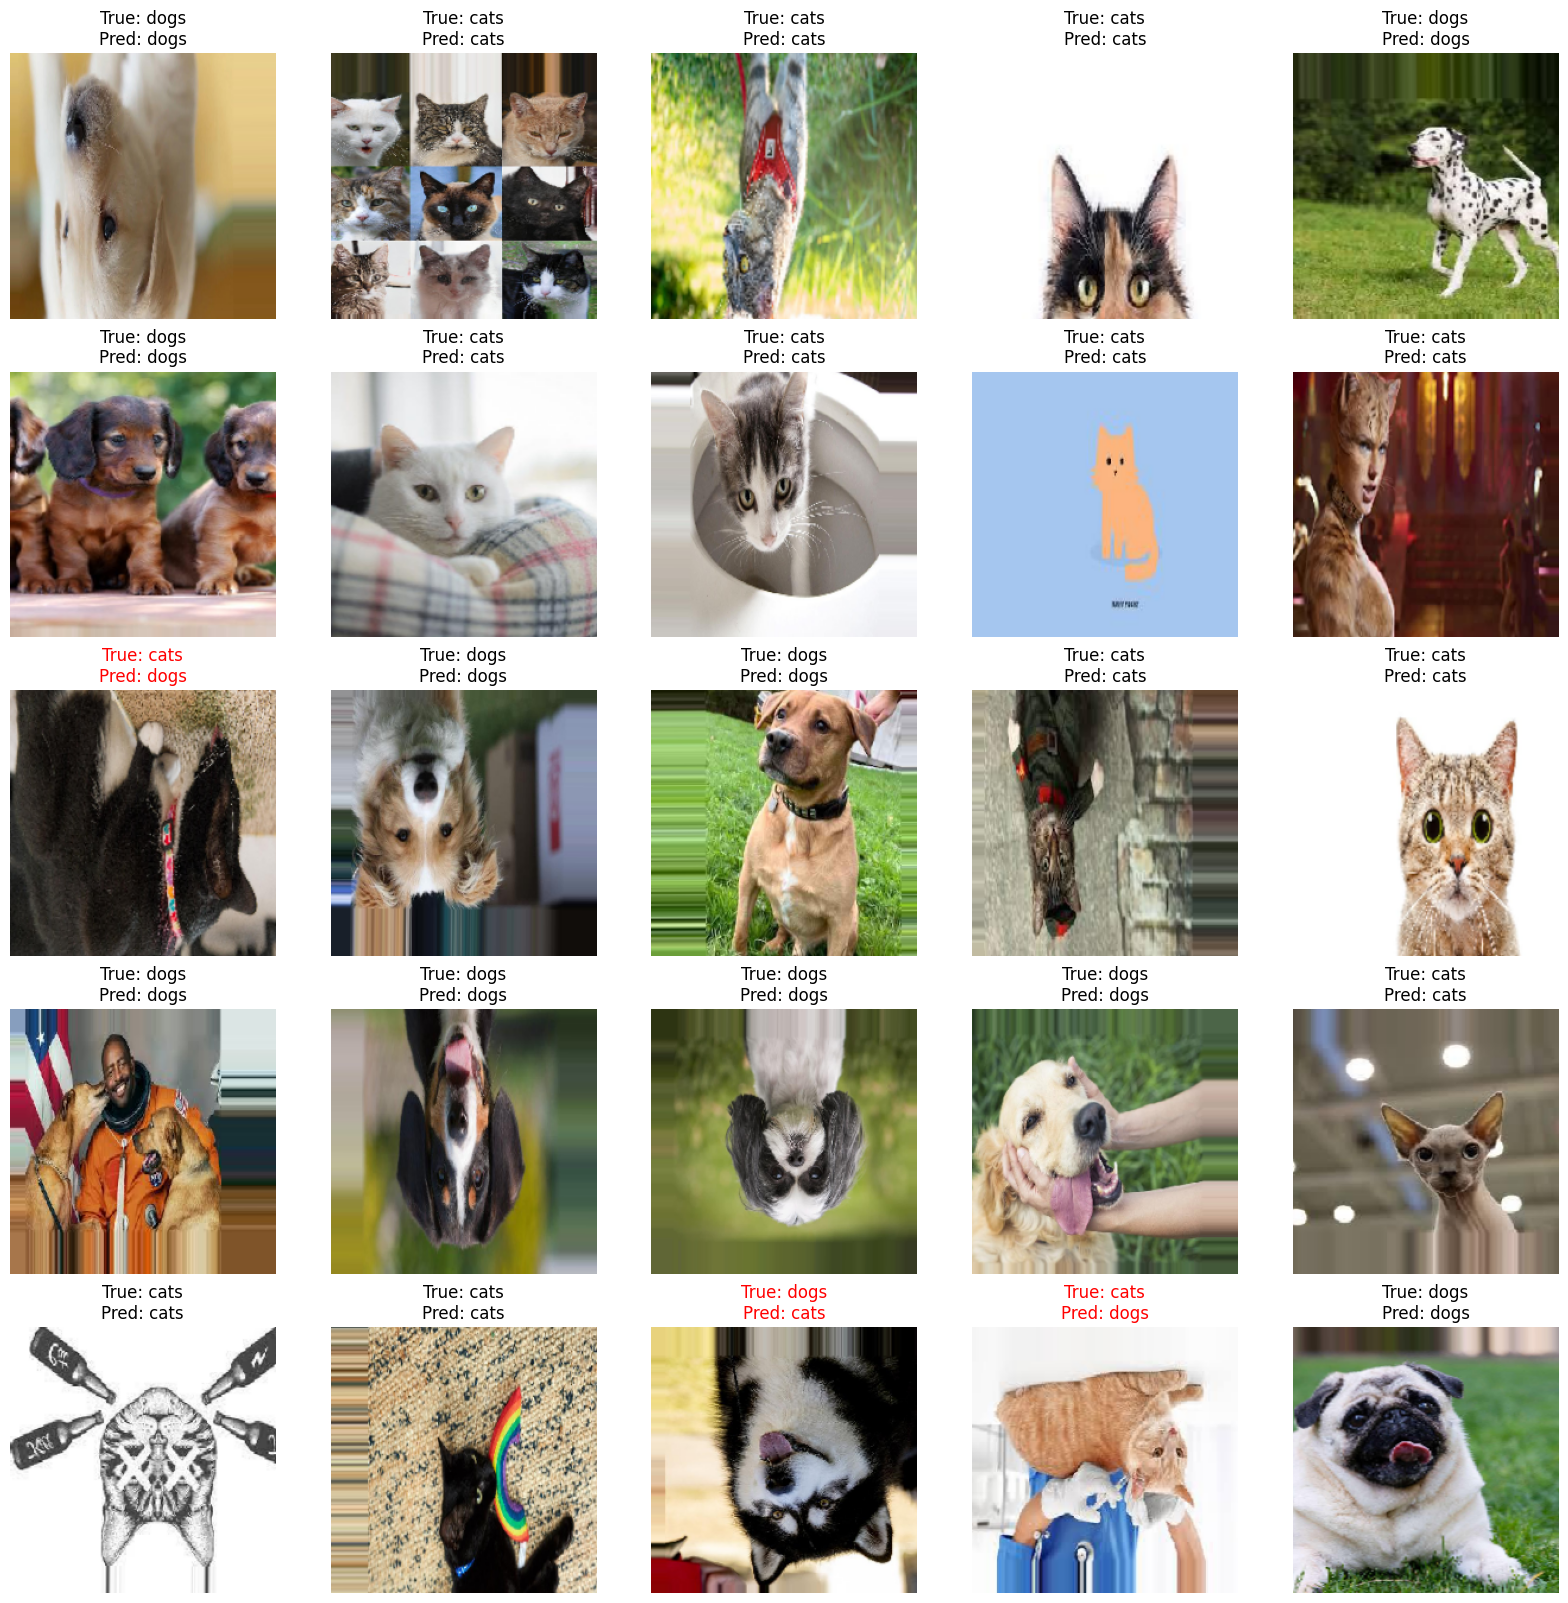

In [20]:
images, labels = test_generator[0]    
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)     
true_classes = np.argmax(labels, axis=1)   
class_labels = list(test_generator.class_indices.keys())  # ['Cat', 'Dog']
def plot_images(images, true_labels, predicted_labels, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(25):  
        plt.subplot(5, 5, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))  
        plt.axis('off')
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}",
                  color="black" if true_label == predicted_label else "red") 
    plt.show()
plot_images(images, true_classes, predicted_classes[:len(images)], class_labels)

In [22]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}